# Basic Regressions

Dans cet exercice, nous avons utilisé deux méthodes de régression linéaire avec régularisation : Lasso et Ridge (puis ElasticNet pour combiner les deux).

Nous avons utilisé l'optimisation bayésienne via la bibliothèque Optuna pour trouver les hyperparamètres optimaux. L'hyperparamètre principal pour les deux méthodes est le coefficient de régularisation alpha, qui contrôle l'ampleur de la régularisation.

In [1]:
import numpy as np
import optuna
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge

/home/alex/Desktop/FTML_Project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_train = np.load(os.path.join("data", "X_train.npy"))
X_test = np.load(os.path.join("data", "X_test.npy"))
y_train = np.load(os.path.join("data", "y_train.npy"))
y_test = np.load(os.path.join("data", "y_test.npy"))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(200, 200)
(200, 1)
(200, 200)
(200, 1)


## Régression Lasso

La régression Lasso ajoute une pénalité $l1$ à la fonction de perte, forçant davantage de poids à devenir nuls. Nous avons utilisé le solveur par défaut (ici qu'un seul solver est disponible).

In [3]:
def objective_lasso(trial):
    """
    Objective function

    This function returnw the r2 score on the test set,
    after fitting a ridge estimator with a given set of hyperparameters.
    """
    alpha = trial.suggest_float("alpha", 1e-12, 1)
    positive = trial.suggest_categorical('positive', [True, False])

    estimator = Lasso(alpha=alpha, positive=positive)
    estimator.fit(X_train, y_train)

    # Returns the R^2 score estimation
    return estimator.score(X_test, y_test)

In [4]:
def create_optuna_study_lasso(storage_name: str):
    """Creation of an optuna object and storage for the study.

    Args:
        storage_name (str): name of the storage.
    """
    if os.path.exists(storage_name):
        os.remove(storage_name)

    # Create a study with the goal of maximizing the R2 score
    return optuna.create_study(
        storage=f"sqlite:///{storage_name}",
        study_name="Ridge_regression",
        load_if_exists=False,
        direction="maximize",
    )

In [5]:
study = create_optuna_study_lasso("lasso.db")
study.optimize(func=objective_lasso, n_trials=100)

print(f"Best R^2 score: {study.best_value} with params:")
for key, value in study.best_trial.params.items():
    if type(value) == float:
        print(f"{key}: {value:.5f}")
    else:
        print(f"{key}: {value}")

    # Extract dataframe from study
    df = study.trials_dataframe()

[I 2024-06-30 16:40:29,149] A new study created in RDB with name: Ridge_regression
[I 2024-06-30 16:40:29,229] Trial 0 finished with value: -0.033927168597252644 and parameters: {'alpha': 0.19485730338343468, 'positive': False}. Best is trial 0 with value: -0.033927168597252644.
[I 2024-06-30 16:40:29,289] Trial 1 finished with value: -0.033927168597252644 and parameters: {'alpha': 0.5651374369271734, 'positive': False}. Best is trial 0 with value: -0.033927168597252644.
[I 2024-06-30 16:40:29,346] Trial 2 finished with value: -0.033927168597252644 and parameters: {'alpha': 0.30598088161537573, 'positive': False}. Best is trial 0 with value: -0.033927168597252644.
[I 2024-06-30 16:40:29,403] Trial 3 finished with value: -0.033927168597252644 and parameters: {'alpha': 0.4905609867995782, 'positive': True}. Best is trial 0 with value: -0.033927168597252644.
[I 2024-06-30 16:40:29,459] Trial 4 finished with value: -0.033927168597252644 and parameters: {'alpha': 0.8060043764336081, 'positi

Best R^2 score: 0.9262208017620727 with params:
alpha: 0.00491
positive: True


Après l'optimisation de Lasso avec 100 essais, nous avons obtenu les meilleurs résultats suivants:

    Meilleur score R² : 0.9262
    Meilleur paramètre alpha : 0.0042

L'impact du coefficient de régularisation sur le score $R^2$ est visualisé ci-dessous :

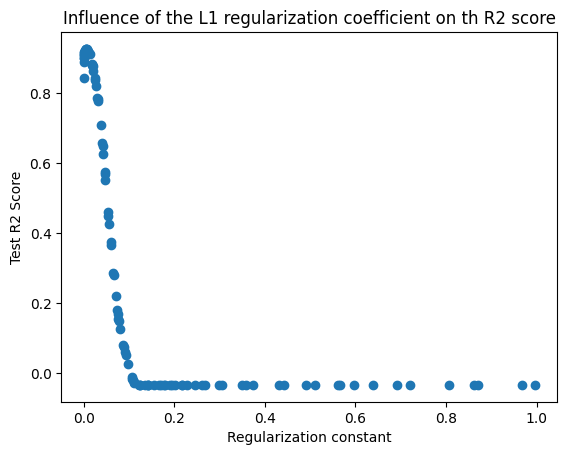

In [6]:
# Analyze the hyperparameters (alpha)
plt.plot(df.params_alpha, df.value, "o")
plt.title("Influence of the L1 regularization coefficient on th R2 score")
plt.xlabel("Regularization constant")
plt.ylabel("Test R2 Score")

#figpath = os.path.join("images", "regularization_lasso.pdf")
#plt.savefig(figpath)
#plt.close()
plt.show()

## Régression Ridge

La régression Ridge ajoute une pénalité $l2$ à la fonction de perte, ce qui aide à prévenir le surapprentissage en pénalisant les grands coefficients.

Nous avons fixé le paramètre 'positive' à True pour le modèle afin de forcer les coefficients à être positifs et ainsi pouvoir utiliser le solver 'lbfgs'. Ce choix a été pris car on a remarqué un boost considérable des performance une fois ce paramètres activé (+ ~10%). Cela est surement dû à la façon dont le dataset a été construit.

In [7]:
def objective_ridge(trial):
    """
    Objective function

    This function returnw the r2 score on the test set,
    after fitting a ridge estimator with a given set of hyperparameters.
    """
    alpha = trial.suggest_float("alpha", 1e-12, 1)

    estimator = Ridge(alpha=alpha, positive=True, solver='lbfgs')
    estimator.fit(X_train, y_train)

    # Returns the R^2 score estimation
    return estimator.score(X_test, y_test)

In [8]:
def create_optuna_study_ridge(storage_name: str):
    """Creation of an optuna object and storage for the study.

    Args:
        storage_name (str): name of the storage.
    """
    if os.path.exists(storage_name):
        os.remove(storage_name)

    # Create a study with the goal of maximizing the R2 score
    return optuna.create_study(
        storage=f"sqlite:///{storage_name}",
        study_name="Ridge_regression",
        load_if_exists=False,
        direction="maximize",
    )

In [9]:
study = create_optuna_study_ridge("ridge.db")
study.optimize(func=objective_ridge, n_trials=100)

print(f"Best R^2 score: {study.best_value} with params:")
for key, value in study.best_trial.params.items():
    if type(value) == float:
        print(f"{key}: {value:.5f}")
    else:
        print(f"{key}: {value}")

[I 2024-06-30 16:40:36,157] A new study created in RDB with name: Ridge_regression
[I 2024-06-30 16:40:36,220] Trial 0 finished with value: 0.8767863059743667 and parameters: {'alpha': 0.8527111468403632}. Best is trial 0 with value: 0.8767863059743667.
[I 2024-06-30 16:40:36,276] Trial 1 finished with value: 0.8779818730084221 and parameters: {'alpha': 0.7941819150901056}. Best is trial 1 with value: 0.8779818730084221.
[I 2024-06-30 16:40:36,328] Trial 2 finished with value: 0.8855362751305996 and parameters: {'alpha': 0.07333922347441098}. Best is trial 2 with value: 0.8855362751305996.
[I 2024-06-30 16:40:36,380] Trial 3 finished with value: 0.8855197979164892 and parameters: {'alpha': 0.07138610088084021}. Best is trial 2 with value: 0.8855362751305996.
[I 2024-06-30 16:40:36,433] Trial 4 finished with value: 0.8859458919417924 and parameters: {'alpha': 0.24178743689531496}. Best is trial 4 with value: 0.8859458919417924.
[I 2024-06-30 16:40:36,482] Trial 5 finished with value: 0.

Best R^2 score: 0.8864271133806659 with params:
alpha: 0.18483


Pour Ridge, après 100 essais, les meilleurs résultats sont les suivants:

    Meilleur score R² : 0.8864
    Meilleur paramètre alpha : 0.1848

La relation entre la constante de régularisation et le score $R^2$ est représentée ci-dessous :

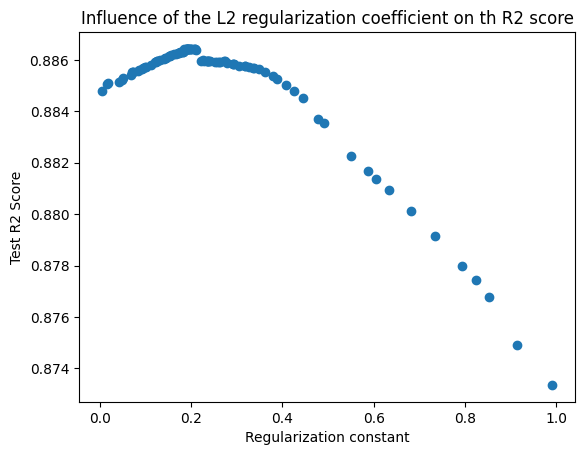

In [10]:
# Extract dataframe from study
df = study.trials_dataframe()

# Analyze the hyperparameters (alpha)
plt.plot(df.params_alpha, df.value, "o")
plt.title("Influence of the L2 regularization coefficient on th R2 score")
plt.xlabel("Regularization constant")
plt.ylabel("Test R2 Score")

#figpath = os.path.join("images", "regularization_ridge.pdf")
#plt.savefig(figpath)
#plt.close()
plt.show()

# Régression avec ElasticNet

Combinons maintenant les deux régularisations avec le modèle ElasticNet pour voir si l'on peut tirer le meilleur des 2 régularisations et obtenir un encore meilleur R2 score. Nous avons utilisé le solveur par défaut (ici qu'un seul solver est disponible).

In [20]:
from sklearn.linear_model import ElasticNet

def objective_elasticnet(trial):
    alpha = trial.suggest_float("alpha", 1e-12, 1)
    l1_ratio = trial.suggest_float("l1_ratio", 0, 1)
    positive = trial.suggest_categorical('positive', [True, False])

    estimator = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, positive=positive)
    estimator.fit(X_train, y_train)

    return estimator.score(X_test, y_test)

In [21]:
def create_optuna_study_elasticnet(storage_name: str):
    if os.path.exists(storage_name):
        os.remove(storage_name)

    return optuna.create_study(
        storage=f"sqlite:///{storage_name}",
        study_name="ElasticNet_regression",
        load_if_exists=False,
        direction="maximize",
    )

In [26]:
study = create_optuna_study_elasticnet("elasticnet.db")
study.optimize(func=objective_elasticnet, n_trials=100)

print(f"Meilleur score R^2 : {study.best_value} avec les paramètres :")
for key, value in study.best_trial.params.items():
    if isinstance(value, float):
        print(f"{key}: {value:.5f}")
    else:
        print(f"{key}: {value}")

[I 2024-06-30 17:26:27,187] A new study created in RDB with name: ElasticNet_regression
[I 2024-06-30 17:26:27,275] Trial 0 finished with value: -0.033927168597252644 and parameters: {'alpha': 0.6822363215013421, 'l1_ratio': 0.6663096284114763, 'positive': True}. Best is trial 0 with value: -0.033927168597252644.
[I 2024-06-30 17:26:27,344] Trial 1 finished with value: -0.033927168597252644 and parameters: {'alpha': 0.3257851939212188, 'l1_ratio': 0.4732948217816949, 'positive': False}. Best is trial 0 with value: -0.033927168597252644.
[I 2024-06-30 17:26:27,411] Trial 2 finished with value: -0.033927168597252644 and parameters: {'alpha': 0.5112316346364018, 'l1_ratio': 0.9921876355998341, 'positive': False}. Best is trial 0 with value: -0.033927168597252644.
[I 2024-06-30 17:26:27,483] Trial 3 finished with value: -0.020145477506834597 and parameters: {'alpha': 0.28801256243926043, 'l1_ratio': 0.350356834365245, 'positive': True}. Best is trial 3 with value: -0.020145477506834597.
[I

Meilleur score R^2 : 0.9258273330446481 avec les paramètres :
alpha: 0.00521
l1_ratio: 0.96917
positive: True


Pour ElasticNet, après 100 essais, nous avons obtenu les meilleurs résultats suivants :
 
    Meilleur score R2 : 0,9258
    Meilleur alpha : 0,0052
    Meilleur l1_ratio : 0,9692

**Dans le cas où on laisse tourner plus longtemps, on remarque que le modèle ElasticNet converge vers Lasso, on obtient donc des résultats similaires à ce modèle.**

La relation entre les hyperparamètres et le score $R^2$ est visualisée ci-dessous :


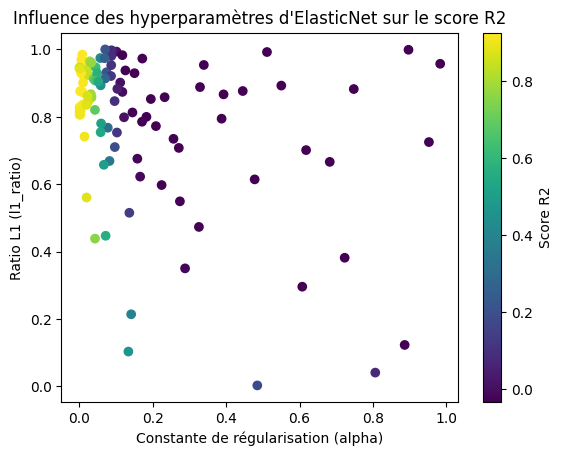

In [27]:
df_elasticnet = study.trials_dataframe()

plt.scatter(df_elasticnet.params_alpha, df_elasticnet.params_l1_ratio, c=df_elasticnet.value, cmap='viridis')
plt.colorbar(label='Score R2')
plt.title("Influence des hyperparamètres d'ElasticNet sur le score R2")
plt.xlabel("Constante de régularisation (alpha)")
plt.ylabel("Ratio L1 (l1_ratio)")
plt.show()

**On remarque que le modèle ElasticNet a un meilleur R2 score lorsque le Ratio $L1$ s'approche de 1, avec un alpha correspondant au meilleur alpha de Lasso.**

## Résumé des résultats
Voici un résumé des résultats obtenus avec les modèles de régression Lasso, Ridge et ElasticNet:
 
 | Modèle | Score \( R^2 \) |
 |--------|-----------------|
 | Lasso  | **0,9262**      |
 | Ridge  | 0,8864          |
 | ElasticNet | 0,9258     |
 
Sachant que ElasticNet semble converger vers Lasso, on peut en conclure que la régression Lasso performe mieux pour ce dataset que la régression Ridge, atteignant un score \( R^2 \) supérieur à l'objectif de 0,88.

